# 🔍 Lab8 Overview: Multimodal Contrastive Representation Learning

In this lab, you'll build and analyze a compact **multimodal contrastive representation learning** system that aligns images with text embeddings. The goal is to understand how contrastive objectives can produce a shared embedding space across modalities.

You will:

- **Prepare** a filtered CIFAR-100 dataset and use a frozen **MobileNetV3 encoder** with a small trainable projection head.  
- **Train** the model using a symmetric contrastive (InfoNCE) loss to associate each image with its corresponding class word.  
- **Evaluate** the learned space through per-class similarity statistics, retrieval performance, confusion matrices, and embedding visualizations.  
- **Test generalization** by applying the model to out-of-distribution (OOD) images.  
- **Interpret** the structure and behaviour of the multimodal embedding space.

---

### 📚 Suggested Reading

For more background and inspiration, see:  
- **CLIP**: *Learning Transferable Visual Models From Natural Language Supervision* — [arXiv paper](https://arxiv.org/abs/2103.00020)
- **DETiC**: *Detecting Twenty-thousand Classes using Image-level Supervision* — [arXiv paper](https://arxiv.org/abs/2201.02605)

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [11]:
# =============================================================================
# Initialization and Environment Setup
# =============================================================================

# 📚 Import Necessary Libraries and Custom Modules
# This cell loads all required Python libraries and custom functions from the
# linked lab files. We import everything at the top for clarity.

import os
import torch
import torch.nn.functional as F

# Importing text processing, analysis, and data utilities from previous labs.
# (lab2: text_network, lab6: text prep/analysis, lab7: text/image prep/analysis)
from lab2 import process_text_network
from lab6_current_best import prepare_visual_genome_text, filter_punctuation_from_network, analyze_embeddings, find_similar_words
from lab7 import load_trained_model, create_mappings, compute_embedding_stats, get_cifar100_vocabulary, analyze_vocabulary_overlap, run_sanity_checks

# Importing all core components for the multimodal training pipeline and
# evaluation from the main script (lab8).
from lab8_local import (
    CIFAR100Filtered,
    ImageEncoder,
    filter_dataset_indices,
    create_data_splits,
    create_dataloaders,
    train_with_early_stopping,
    run_epoch,
    collect_embeddings,
    print_analysis_results,
    create_visualizations,
    print_example_retrievals,
    process_ood_images,
    compute_alignment_metrics,
    print_final_report
)

# 🖥️ Determine the Execution Device
# We check for an available NVIDIA GPU (CUDA) for accelerated training.
# If no GPU is found, the code defaults to the CPU.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# The environment is now set up and all required functions are imported.

Using device: cuda


In [12]:
import torch
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Torch CUDA version:", torch.version.cuda)


2.9.1+cu128
CUDA available: True
Torch CUDA version: 12.8


In [13]:
# =============================================================================
# 🚀 STAGE 1: Load Corpus & Build Vocabulary from Visual Genome
# =============================================================================

# This initial stage prepares the text data required for the text-side embeddings.
# We use the Visual Genome (VG) dataset's region descriptions as our text corpus,
# which provides rich, descriptive language for objects and scenes.

print("\n[STAGE 1] Loading Data & Building Vocabulary")
print("-" * 70)

# 1. 📂 Define Constants and Check for Text Corpus
# We define the source URL for the VG data, the local file path, and parameters
# for filtering out very rare words and common punctuation during network creation.

TEXT_FILE = 'vg_text.txt'
ZIP_URL = "https://homes.cs.washington.edu/~ranjay/visualgenome/data/dataset/region_descriptions.json.zip"
RARE_THRESHOLD = 0.00025 # Words appearing less frequently than this threshold are marked as '<RARE>'
PUNCTUATION_TOKENS = {'.', ',', '<RARE>', "'"}

if not os.path.exists(TEXT_FILE):
    print(f"Text file not found. Downloading corpus from {ZIP_URL}...")
    # Calls a helper function to download, unzip, parse the JSON, and save the text descriptions.
    TEXT_FILE = prepare_visual_genome_text(
        zip_url=ZIP_URL,
        zip_path="region_descriptions.json.zip",
        json_path="region_descriptions.json",
        output_path=TEXT_FILE
    )
else:
    print(f"✓ Text file '{TEXT_FILE}' already exists. Skipping download and parsing.")

# 2. 🏗️ Build the Co-occurrence Network (Graph)
# The text file is processed to create a word co-occurrence network. This graph
# forms the basis for learning context-dependent word embeddings (Skip-gram, in spirit).
# The 'inverted' distance mode means closer words have a stronger connection weight.

print("\nProcessing text to build co-occurrence network...")
network_data = process_text_network(
    TEXT_FILE,
    rare_threshold=RARE_THRESHOLD,
    rare_token="<RARE>",
    distance_mode="inverted",
    verbose=True # Prints progress during network construction
)

# 3. 🗑️ Clean the Vocabulary
# Punctuation and the placeholder for rare words are filtered out from the final
# vocabulary since they are not useful for visual-semantic alignment.

network_data = filter_punctuation_from_network(network_data, punctuation_tokens=PUNCTUATION_TOKENS)

# 4. 📊 Final Summary
# Extract the final vocabulary (nodes) and report the network statistics.
nodes = network_data['nodes']
vocab_size = len(nodes)

print(f"\n{'-'*70}")
print(f"✓ STAGE 1 Complete: Vocabulary built.")
print(f"  Total vocabulary size (nodes): {vocab_size} words")
print(f"  Total graph edges (co-occurrences): {network_data['graph'].number_of_edges():,}")


[STAGE 1] Loading Data & Building Vocabulary
----------------------------------------------------------------------
✓ Text file 'vg_text.txt' already exists. Skipping download and parsing.

Processing text to build co-occurrence network...
Loaded text: 154199868 characters
Tokenized: 27533256 tokens
Sample tokens: ['gup', 'jie', 'lotf', 'eyelidded', 'aremostly', 'koalas', 'oranfges', 'scurbs', 'restarm', 'cuttin', 'resolute', 'contruction', 'verge', 'fls', 'windopw', 'reflexted', 'picklet', 'compatible', 'sandman', 'parga']
Replaced 62380 rare tokens (threshold=0.00025)
Final vocabulary: 456 unique tokens
Sample tokens: ['cloth', 'he', 'ground', 'bear', 'statue', 'bird', 'on', 'off', 'mouth', 'visible', 'stop', 'this', 'wooden', 'paper', 'jeans', 'trash', 'an', 'couch', 'broccoli', 'bicycle']
Graph: 456 nodes, 84581 edges
Top tokens by frequency:
   1. '<RARE>' (freq=4416304)
   2. 'a' (freq=2220903)
   3. 'the' (freq=2155082)
   4. 'on' (freq=1396037)
   5. 'of' (freq=980462)
   6. '

In [14]:
# =============================================================================
# STAGE 2: Load Pre-trained Text Model & Compute Embedding Statistics
# =============================================================================

# This stage loads the text-side embeddings (e.g., Skip-gram or GloVe) that were
# pre-trained on the Visual Genome co-occurrence network from STAGE 1.
# These embeddings represent the semantic meaning of each word in the vocabulary.
# We also compute statistical properties of this embedding space, which are crucial
# for the subsequent genetic algorithm or training initialization.

print("\n[STAGE 2] Loading Model & Analyzing Embedding Space")
print("-" * 70)

# 1. 📂 Define Model Configuration and Load Embeddings

MODEL_PATH = 'best_skipgram_523words.pth' # Path to the file containing the pre-trained embedding matrix.
EMBEDDING_DIM = 96               # Dimensionality of the word vectors.
DROPOUT = 0.3                    # Dropout rate used during the original training (if applicable).

# The `load_trained_model` function initializes the network and loads the weights.
# It returns the PyTorch model (for potential fine-tuning) and the embedding matrix itself.
#model, embeddings = load_trained_model(
 #   model_path=MODEL_PATH,
 #   vocab_size=vocab_size,         # Use the size determined in STAGE 1
 #   embedding_dim=EMBEDDING_DIM,
#    dropout=DROPOUT
#)
MODEL_PATH = "best_skipgram_523words.pth"  # ή skipgram_with_inserted_words.pth
ckpt = torch.load(MODEL_PATH, map_location="cpu")  # ΠΑΝΤΑ cpu για numpy stats

embeddings_cpu = ckpt["embeddings"].float()   # (523,96) torch tensor on CPU
vocab = ckpt["vocab"]                         # list length 523

word_to_idx = {w:i for i,w in enumerate(vocab)}
idx_to_word = {i:w for w,i in word_to_idx.items()}

# αν θες stats:
embedding_stats = compute_embedding_stats(embeddings_cpu.numpy())

# για training:
embeddings = embeddings_cpu.to(device)


embeddings = embeddings_cpu.to(device)               # GPU, για training
vocab = ckpt["vocab"]                   # list length: 523

# 2. 🗺️ Create Word-Index Mappings
# These mappings are essential for looking up the correct embedding vector
# (by index) for a given word and vice-versa.

word_to_idx = {w:i for i,w in enumerate(vocab)}
idx_to_word = {i:w for w,i in word_to_idx.items()}

# 3. 📈 Compute Statistical Properties
# Analyzing the embedding space helps set hyper-parameters for optimization.
# Specifically, the global standard deviation is often used to tune the mutation
# rate in evolutionary algorithms or to initialize a new layer's weights.
# 4. 📊 Final Summary
print(f"\n{'-'*70}")
print(f"✓ STAGE 2 Complete: Model loaded and stats computed.")
print(f"  Embedding matrix shape: {embeddings.shape} (Total words × Dimension)")
print(f"  Key Stats for Fitness Function:")
print(f"    ├─ Mean Vector Norm: {embedding_stats['mean_norm']:.4f} (Average magnitude of vectors)")
print(f"    ├─ Std. Dev of Norms: {embedding_stats['std_norm']:.4f}")
print(f"    └─ Global Std. Dev: {embedding_stats['global_std']:.4f} (Used for controlling search step size)")


[STAGE 2] Loading Model & Analyzing Embedding Space
----------------------------------------------------------------------

----------------------------------------------------------------------
✓ STAGE 2 Complete: Model loaded and stats computed.
  Embedding matrix shape: torch.Size([523, 96]) (Total words × Dimension)
  Key Stats for Fitness Function:
    ├─ Mean Vector Norm: 1.7073 (Average magnitude of vectors)
    ├─ Std. Dev of Norms: 0.3418
    └─ Global Std. Dev: 0.1777 (Used for controlling search step size)


In [15]:
# =============================================================================
# 🔎 STAGE 3: Sanity Checks and Vocabulary Analysis
# =============================================================================

# This stage performs two essential checks:
# 1. **Sanity Checks** on the loaded text embeddings to ensure they are semantically sound
#    (e.g., that similar words have high cosine similarity).
# 2. **Vocabulary Analysis** to determine which classes from the CIFAR-100 dataset
#    have corresponding words in our pre-trained Visual Genome vocabulary.

# 1. 🧪 Perform Semantic Sanity Checks
# The `run_sanity_checks` function tests the quality of the loaded word embeddings
# by finding the nearest neighbors for a few common words. This confirms that the
# embedding space is semantically meaningful.

#run_sanity_checks(model, embeddings, nodes, word_to_idx)




# Get the 100 class names from CIFAR-100 dataset.
cifar_vocab = get_cifar100_vocabulary()

# Check for overlap between CIFAR-100 class words and the Visual Genome vocabulary.
# This step identifies which classes we can actually train/test on.

missing = [w for w in cifar_vocab if w not in word_to_idx]
assert len(missing) == 0, f"Missing CIFAR words in 523 vocab: {missing}"




Loading CIFAR-100 vocabulary...
✓ CIFAR-100 vocabulary loaded: 100 classes


In [7]:
## CALCULATE CIFAR MEAN, STD
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def compute_cifar100_mean_std(root="./data", batch_size=512, num_workers=2):
    # ΜΟΝΟ ToTensor για να μη “πειράξεις” τα στατιστικά
    ds = datasets.CIFAR100(
        root=root,
        train=True,
        download=True,
        transform=transforms.ToTensor()
    )
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    channel_sum = torch.zeros(3)
    channel_sum_sq = torch.zeros(3)
    num_pixels = 0

    for x, _ in loader:
        # x: (B, 3, 32, 32) σε [0,1]
        b, c, h, w = x.shape
        num_pixels += b * h * w

        channel_sum += x.sum(dim=[0, 2, 3])
        channel_sum_sq += (x ** 2).sum(dim=[0, 2, 3])

    mean = channel_sum / num_pixels
    var = (channel_sum_sq / num_pixels) - (mean ** 2)
    std = torch.sqrt(var)

    return mean.tolist(), std.tolist()

cifar_mean, cifar_std = compute_cifar100_mean_std(root="./data")
print("CIFAR-100 mean:", cifar_mean)
print("CIFAR-100 std: ", cifar_std)


CIFAR-100 mean: [0.5070750117301941, 0.4865489602088928, 0.4409179389476776]
CIFAR-100 std:  [0.26733455061912537, 0.2564384341239929, 0.2761504054069519]


In [ ]:

TRAIN_CONFIG = {
    'proj_dim': 96,                         # Output dimension of the vision projection head
    'lr': 5e-4,                             # AdamW learning rate
    'weight_decay': 1e-3,                   # L2 regularization
    'temperature': 1.0,                     # Scaling factor for the InfoNCE logits (controls contrast sharpness)
    'epochs': 100,                          # Maximum number of epochs
    'patience': 13,                         # Early stopping patience based on validation similarity
    'batch_sizes': {'train': 512, 'eval': 256},
    'save_path': 'best_cifar100_projection.pth'
}


In [17]:
# =============================================================================
# 🧠 STAGE 4: CLIP-Style Contrastive Learning Setup and Training
# =============================================================================

# This is the core stage where the visual encoder's projection head is trained
# to align image embeddings (CIFAR-100) with their corresponding text embeddings
# (Visual Genome vocabulary). This process uses the InfoNCE loss, a form of
# contrastive learning analogous to the training used in models like CLIP.
from torchvision import transforms

print("\n[STAGE 4] CLIP-Style Contrastive Learning with Full Vocabulary")
print("-" * 70)

# 1. ⚙️ Define Training Configuration
# The configuration sets crucial hyper-parameters for optimization, loss function,
# and early stopping.

TRAIN_CONFIG = {
    'proj_dim': 96,                         # Output dimension of the vision projection head
    'lr': 5e-4,                             # AdamW learning rate
    'weight_decay': 1e-3,                   # L2 regularization
    'temperature': 1.0,                     # Scaling factor for the InfoNCE logits (controls contrast sharpness)
    'epochs': 100,                          # Maximum number of epochs
    'patience': 13,                         # Early stopping patience based on validation similarity
    'batch_sizes': {'train': 512, 'eval': 256},
    'save_path': 'best_clip_vision_model.pth'
}

# 2. 📝 Define Target Vocabulary and Embeddings

# Get the subset of CIFAR-100 class words that exist in the pre-trained VG vocabulary.
#class_words = [w for w in cifar_vocab if w in word_to_idx]

class_words = cifar_vocab   # και τα 100


# Create label mapping for CIFAR-100 indices to their word and embedding index.
label_to_word = {i: word for i, word in enumerate(cifar_vocab)}
label_to_emb_idx = {i: word_to_idx[word] for i, word in enumerate(cifar_vocab) if word in word_to_idx}
assert len(label_to_emb_idx) == 100

# Extract ALL text embeddings (Full Vocabulary)
# This full set of embeddings will be used later for **zero-shot prediction** on
# the test set, allowing the model to classify images against the entire VG vocabulary.
all_vocab_words = list(word_to_idx.keys())
all_text_emb = embeddings.to(device).float()
all_text_emb = F.normalize(all_text_emb, p=2, dim=1)


# Extract ONLY the Training Class Embeddings (Subset)
# This subset is used *within the batch* for computing the **symmetric InfoNCE loss**
# ($\mathcal{L}_{I \to T} + \mathcal{L}_{T \to I}$).
training_indices = torch.tensor(
    [word_to_idx[w] for w in class_words],
    device=device
)

training_text_emb = all_text_emb[training_indices]

print(f"\nText embedding configuration:")
print(f"  ├─ Full vocabulary embeddings (All VG words): {all_text_emb.shape[0]} words (for OOD analysis)")
print(f"  └─ Training class embeddings: {training_text_emb.shape[0]} classes (for contrastive learning)")

# 3. 💾 Data Preparation: Create Splits and DataLoaders
print("\n[Data Split] Creating Train/Val/Test splits...")

# Load the full CIFAR-100 datasets
train_full = CIFAR100Filtered(root="./data", split="train")
test_full = CIFAR100Filtered(root="./data", split="val")

# πάρε ένα δείγμα label y από dataset, δες τη λέξη του:
x0, y0 = train_full[0]
print("label:", y0, "word:", cifar_vocab[y0])

import random
for _ in range(5):
    i = random.randrange(len(train_full))
    _, y = train_full[i]          # πάρε label από __getitem__
    print(i, y, cifar_vocab[y])


# Filter indices to include only samples belonging to the overlapping classes
all_train_idx = filter_dataset_indices(train_full, label_to_emb_idx)
test_idx = filter_dataset_indices(test_full, label_to_emb_idx)

labels = [train_full[i][1] for i in range(len(train_full))]
assert len(set(labels)) == 100
assert len(all_train_idx) == len(train_full)   # ιδανικά

# Split the training data into training and validation sets
train_idx, val_idx = create_data_splits(all_train_idx, val_ratio=0.2, seed=42)

print(f"Train samples: {len(train_idx):,} (for training the projection head)")
print(f"Val samples: {len(val_idx):,} (for early stopping)")
print(f"Test samples: {len(test_idx):,} (for final evaluation)")

#ΑUTOS O TRAIN TRANSFORMER VELTIWSE TON ARXIKO
#train_transform = transforms.Compose([
#    transforms.RandomCrop(32, padding=4),
#    transforms.RandomHorizontalFlip(),
#    transforms.Resize(224),
#    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]),
#])

#DOKIMI KAI KATI AKOMA POU PROTEINE TO CHAT GPT ME COLORJITTER.
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.02),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]),
])

eval_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]),
])

# Create PyTorch DataLoaders for efficient batch processing
dataloaders = create_dataloaders(train_idx, val_idx, test_idx, TRAIN_CONFIG['batch_sizes'],  train_transform=train_transform,eval_transform=eval_transform)


[STAGE 4] CLIP-Style Contrastive Learning with Full Vocabulary
----------------------------------------------------------------------

Text embedding configuration:
  ├─ Full vocabulary embeddings (All VG words): 523 words (for OOD analysis)
  └─ Training class embeddings: 100 classes (for contrastive learning)

[Data Split] Creating Train/Val/Test splits...
label: 19 word: cattle
7930 16 can
26604 0 apple
17333 54 orchid
5727 20 chair
29693 2 baby
Train samples: 40,000 (for training the projection head)
Val samples: 10,000 (for early stopping)
Test samples: 10,000 (for final evaluation)


In [ ]:
# =============================================================================
# 🧠 STAGE 4: CLIP-Style Contrastive Learning Setup and Training
# =============================================================================

# This is the core stage where the visual encoder's projection head is trained
# to align image embeddings (CIFAR-100) with their corresponding text embeddings
# (Visual Genome vocabulary). This process uses the InfoNCE loss, a form of
# contrastive learning analogous to the training used in models like CLIP.

print("\n[STAGE 4] CLIP-Style Contrastive Learning with Full Vocabulary")
print("-" * 70)

# 1. ⚙️ Define Training Configuration
# The configuration sets crucial hyper-parameters for optimization, loss function,
# and early stopping.

TRAIN_CONFIG = {
    'proj_dim': 96,                         # Output dimension of the vision projection head
    'lr': 5e-4,                             # AdamW learning rate
    'weight_decay': 1e-3,                   # L2 regularization
    'temperature': 1.0,                     # Scaling factor for the InfoNCE logits (controls contrast sharpness)
    'epochs': 100,                          # Maximum number of epochs
    'patience': 13,                         # Early stopping patience based on validation similarity
    'batch_sizes': {'train': 512, 'eval': 256},
    'save_path': 'best_clip_vision_model.pth'
}

# 2. 📝 Define Target Vocabulary and Embeddings

# Get the subset of CIFAR-100 class words that exist in the pre-trained VG vocabulary.
#class_words = [w for w in cifar_vocab if w in word_to_idx]

class_words = cifar_vocab   # και τα 100


# Create label mapping for CIFAR-100 indices to their word and embedding index.
label_to_word = {i: word for i, word in enumerate(cifar_vocab)}
label_to_emb_idx = {i: word_to_idx[word] for i, word in enumerate(cifar_vocab) if word in word_to_idx}
assert len(label_to_emb_idx) == 100

# Extract ALL text embeddings (Full Vocabulary)
# This full set of embeddings will be used later for **zero-shot prediction** on
# the test set, allowing the model to classify images against the entire VG vocabulary.
all_vocab_words = list(word_to_idx.keys())
all_text_emb = embeddings.to(device).float()
all_text_emb = F.normalize(all_text_emb, p=2, dim=1)


# Extract ONLY the Training Class Embeddings (Subset)
# This subset is used *within the batch* for computing the **symmetric InfoNCE loss**
# ($\mathcal{L}_{I \to T} + \mathcal{L}_{T \to I}$).
training_indices = torch.tensor(
    [word_to_idx[w] for w in class_words],
    device=device
)

training_text_emb = all_text_emb[training_indices]

print(f"\nText embedding configuration:")
print(f"  ├─ Full vocabulary embeddings (All VG words): {all_text_emb.shape[0]} words (for OOD analysis)")
print(f"  └─ Training class embeddings: {training_text_emb.shape[0]} classes (for contrastive learning)")

# 3. 💾 Data Preparation: Create Splits and DataLoaders
print("\n[Data Split] Creating Train/Val/Test splits...")

# Load the full CIFAR-100 datasets
train_full = CIFAR100Filtered(root="./data", split="train")
test_full = CIFAR100Filtered(root="./data", split="val")

# πάρε ένα δείγμα label y από dataset, δες τη λέξη του:
x0, y0 = train_full[0]
print("label:", y0, "word:", cifar_vocab[y0])

import random
for _ in range(5):
    i = random.randrange(len(train_full))
    _, y = train_full[i]          # πάρε label από __getitem__
    print(i, y, cifar_vocab[y])


# Filter indices to include only samples belonging to the overlapping classes
all_train_idx = filter_dataset_indices(train_full, label_to_emb_idx)
test_idx = filter_dataset_indices(test_full, label_to_emb_idx)

labels = [train_full[i][1] for i in range(len(train_full))]
assert len(set(labels)) == 100
assert len(all_train_idx) == len(train_full)   # ιδανικά

# Split the training data into training and validation sets
train_idx, val_idx = create_data_splits(all_train_idx, val_ratio=0.2, seed=42)

print(f"Train samples: {len(train_idx):,} (for training the projection head)")
print(f"Val samples: {len(val_idx):,} (for early stopping)")
print(f"Test samples: {len(test_idx):,} (for final evaluation)")

#ΑUTOS O TRAIN TRANSFORMER VELTIWSE TON ARXIKO
#train_transform = transforms.Compose([
#    transforms.RandomCrop(32, padding=4),
#    transforms.RandomHorizontalFlip(),
#    transforms.Resize(224),
#    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]),
#])

#DOKIMI KAI KATI AKOMA POU PROTEINE TO CHAT GPT ME COLORJITTER.
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.02),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]),
])

eval_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]),
])

# Create PyTorch DataLoaders for efficient batch processing
dataloaders = create_dataloaders(train_idx, val_idx, test_idx, TRAIN_CONFIG['batch_sizes'],  train_transform=train_transform,eval_transform=eval_transform)

# 4. 🧠 Initialize and Train Model
# The ImageEncoder uses a frozen MobileNetV3 backbone and a trainable projection head.
#vision_model = ImageEncoder(proj_dim=TRAIN_CONFIG['proj_dim'], device=device)

# Start training with early stopping based on validation similarity
#history, best_epoch, best_val_sim, best_val_loss = train_with_early_stopping(
#    vision_model, dataloaders, training_text_emb, class_words,
#    label_to_word, TRAIN_CONFIG, device
#)

# 5. 🎉 Final Training Summary
#print("\n" + "="*70)
#print("✓ Training Complete!")
#print(f"Best model from epoch {best_epoch}")
#print(f"Best validation similarity: {best_val_sim:.4f}")
#print(f"Best validation loss: {best_val_loss:.4f}")
#print("="*70)


[STAGE 4] CLIP-Style Contrastive Learning with Full Vocabulary
----------------------------------------------------------------------

Text embedding configuration:
  ├─ Full vocabulary embeddings (All VG words): 523 words (for OOD analysis)
  └─ Training class embeddings: 100 classes (for contrastive learning)

[Data Split] Creating Train/Val/Test splits...
label: 19 word: cattle
2824 60 plain
21079 45 lobster
12689 98 woman
26944 48 motorcycle
7461 41 lawn_mower
Train samples: 40,000 (for training the projection head)
Val samples: 10,000 (for early stopping)
Test samples: 10,000 (for final evaluation)

Training (max 100 epochs, patience=13)


100%|██████████| 40/40 [00:19<00:00,  2.06it/s]


Epoch   1 | Train Loss: 5.9931 | Val Loss: 5.2508 | Val Sim: 0.3127 | LR: 0.000500
          Learnable temperature: 0.9573
 ✓ New best model saved! (Val Sim: 0.3127)


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch   2 | Train Loss: 5.9068 | Val Loss: 5.2275 | Val Sim: 0.3252 | LR: 0.000500
          Learnable temperature: 0.9141
 ✓ New best model saved! (Val Sim: 0.3252)


100%|██████████| 40/40 [00:17<00:00,  2.33it/s]


Epoch   3 | Train Loss: 5.8705 | Val Loss: 5.2072 | Val Sim: 0.3316 | LR: 0.000499
          Learnable temperature: 0.8729
 ✓ New best model saved! (Val Sim: 0.3316)


100%|██████████| 40/40 [00:23<00:00,  1.70it/s]


Epoch   4 | Train Loss: 5.8433 | Val Loss: 5.1850 | Val Sim: 0.3433 | LR: 0.000498
          Learnable temperature: 0.8337
 ✓ New best model saved! (Val Sim: 0.3433)


100%|██████████| 40/40 [00:16<00:00,  2.38it/s]


Epoch   5 | Train Loss: 5.8164 | Val Loss: 5.1430 | Val Sim: 0.3705 | LR: 0.000497
          Learnable temperature: 0.7959
 ✓ New best model saved! (Val Sim: 0.3705)


100%|██████████| 40/40 [00:23<00:00,  1.71it/s]


Epoch   6 | Train Loss: 5.7904 | Val Loss: 5.0992 | Val Sim: 0.3889 | LR: 0.000496
          Learnable temperature: 0.7598
 ✓ New best model saved! (Val Sim: 0.3889)


100%|██████████| 40/40 [00:16<00:00,  2.41it/s]


Epoch   7 | Train Loss: 5.7648 | Val Loss: 5.0615 | Val Sim: 0.3997 | LR: 0.000494
          Learnable temperature: 0.7252
 ✓ New best model saved! (Val Sim: 0.3997)


100%|██████████| 40/40 [00:16<00:00,  2.38it/s]


Epoch   8 | Train Loss: 5.7371 | Val Loss: 5.0322 | Val Sim: 0.4005 | LR: 0.000492
          Learnable temperature: 0.6917
 ✓ New best model saved! (Val Sim: 0.4005)


100%|██████████| 40/40 [00:16<00:00,  2.45it/s]


Epoch   9 | Train Loss: 5.7108 | Val Loss: 5.0024 | Val Sim: 0.4097 | LR: 0.000490
          Learnable temperature: 0.6597
 ✓ New best model saved! (Val Sim: 0.4097)


100%|██████████| 40/40 [00:16<00:00,  2.42it/s]


Epoch  10 | Train Loss: 5.6823 | Val Loss: 4.9691 | Val Sim: 0.4160 | LR: 0.000488
          Learnable temperature: 0.6291
 ✓ New best model saved! (Val Sim: 0.4160)


100%|██████████| 40/40 [00:16<00:00,  2.39it/s]


Epoch  11 | Train Loss: 5.6525 | Val Loss: 4.9396 | Val Sim: 0.4180 | LR: 0.000485
          Learnable temperature: 0.5998
 ✓ New best model saved! (Val Sim: 0.4180)


100%|██████████| 40/40 [00:16<00:00,  2.38it/s]


Epoch  12 | Train Loss: 5.6230 | Val Loss: 4.9129 | Val Sim: 0.4159 | LR: 0.000482
          Learnable temperature: 0.5718
 → No improvement (1/13)


100%|██████████| 40/40 [00:20<00:00,  2.00it/s]


Epoch  13 | Train Loss: 5.5889 | Val Loss: 4.8806 | Val Sim: 0.4150 | LR: 0.000479
          Learnable temperature: 0.5449
 → No improvement (2/13)


100%|██████████| 40/40 [00:18<00:00,  2.19it/s]


Epoch  14 | Train Loss: 5.5585 | Val Loss: 4.8490 | Val Sim: 0.4099 | LR: 0.000476
          Learnable temperature: 0.5194
 → No improvement (3/13)


100%|██████████| 40/40 [00:18<00:00,  2.18it/s]


Epoch  15 | Train Loss: 5.5253 | Val Loss: 4.8125 | Val Sim: 0.4141 | LR: 0.000473
          Learnable temperature: 0.4951
 → No improvement (4/13)


100%|██████████| 40/40 [00:17<00:00,  2.23it/s]


Epoch  16 | Train Loss: 5.4910 | Val Loss: 4.7809 | Val Sim: 0.4181 | LR: 0.000469
          Learnable temperature: 0.4721
 ✓ New best model saved! (Val Sim: 0.4181)


100%|██████████| 40/40 [00:18<00:00,  2.21it/s]


Epoch  17 | Train Loss: 5.4516 | Val Loss: 4.7422 | Val Sim: 0.4177 | LR: 0.000465
          Learnable temperature: 0.4500
 → No improvement (1/13)


100%|██████████| 40/40 [00:18<00:00,  2.20it/s]


Epoch  18 | Train Loss: 5.4168 | Val Loss: 4.7074 | Val Sim: 0.4135 | LR: 0.000461
          Learnable temperature: 0.4292
 → No improvement (2/13)


100%|██████████| 40/40 [00:16<00:00,  2.36it/s]


Epoch  19 | Train Loss: 5.3783 | Val Loss: 4.6704 | Val Sim: 0.4159 | LR: 0.000457
          Learnable temperature: 0.4094
 → No improvement (3/13)


100%|██████████| 40/40 [00:16<00:00,  2.41it/s]


Epoch  20 | Train Loss: 5.3387 | Val Loss: 4.6331 | Val Sim: 0.4144 | LR: 0.000452
          Learnable temperature: 0.3907
 → No improvement (4/13)


100%|██████████| 40/40 [00:16<00:00,  2.39it/s]


Epoch  21 | Train Loss: 5.2975 | Val Loss: 4.5937 | Val Sim: 0.4170 | LR: 0.000448
          Learnable temperature: 0.3730
 → No improvement (5/13)


100%|██████████| 40/40 [00:23<00:00,  1.69it/s]


Epoch  22 | Train Loss: 5.2552 | Val Loss: 4.5540 | Val Sim: 0.4199 | LR: 0.000443
          Learnable temperature: 0.3563
 ✓ New best model saved! (Val Sim: 0.4199)


100%|██████████| 40/40 [00:20<00:00,  1.98it/s]


Epoch  23 | Train Loss: 5.2127 | Val Loss: 4.5119 | Val Sim: 0.4181 | LR: 0.000438
          Learnable temperature: 0.3404
 → No improvement (1/13)


100%|██████████| 40/40 [00:17<00:00,  2.29it/s]


Epoch  24 | Train Loss: 5.1700 | Val Loss: 4.4668 | Val Sim: 0.4193 | LR: 0.000432
          Learnable temperature: 0.3255
 → No improvement (2/13)


100%|██████████| 40/40 [00:19<00:00,  2.10it/s]


Epoch  25 | Train Loss: 5.1266 | Val Loss: 4.4290 | Val Sim: 0.4198 | LR: 0.000427
          Learnable temperature: 0.3115
 → No improvement (3/13)


100%|██████████| 40/40 [00:22<00:00,  1.78it/s]


Epoch  26 | Train Loss: 5.0814 | Val Loss: 4.3865 | Val Sim: 0.4231 | LR: 0.000421
          Learnable temperature: 0.2982
 ✓ New best model saved! (Val Sim: 0.4231)


100%|██████████| 40/40 [00:22<00:00,  1.81it/s]


Epoch  27 | Train Loss: 5.0400 | Val Loss: 4.3435 | Val Sim: 0.4216 | LR: 0.000415
          Learnable temperature: 0.2858
 → No improvement (1/13)


100%|██████████| 40/40 [00:23<00:00,  1.73it/s]


Epoch  28 | Train Loss: 4.9917 | Val Loss: 4.3010 | Val Sim: 0.4232 | LR: 0.000409
          Learnable temperature: 0.2740
 ✓ New best model saved! (Val Sim: 0.4232)


100%|██████████| 40/40 [00:16<00:00,  2.39it/s]


Epoch  29 | Train Loss: 4.9462 | Val Loss: 4.2579 | Val Sim: 0.4217 | LR: 0.000403
          Learnable temperature: 0.2630
 → No improvement (1/13)


100%|██████████| 40/40 [00:16<00:00,  2.40it/s]


Epoch  30 | Train Loss: 4.8995 | Val Loss: 4.2170 | Val Sim: 0.4187 | LR: 0.000397
          Learnable temperature: 0.2526
 → No improvement (2/13)


100%|██████████| 40/40 [00:16<00:00,  2.38it/s]


Epoch  31 | Train Loss: 4.8527 | Val Loss: 4.1752 | Val Sim: 0.4233 | LR: 0.000391
          Learnable temperature: 0.2428
 ✓ New best model saved! (Val Sim: 0.4233)


100%|██████████| 40/40 [00:16<00:00,  2.38it/s]


Epoch  32 | Train Loss: 4.8070 | Val Loss: 4.1336 | Val Sim: 0.4187 | LR: 0.000384
          Learnable temperature: 0.2336
 → No improvement (1/13)


100%|██████████| 40/40 [00:18<00:00,  2.19it/s]


Epoch  33 | Train Loss: 4.7657 | Val Loss: 4.0867 | Val Sim: 0.4247 | LR: 0.000377
          Learnable temperature: 0.2250
 ✓ New best model saved! (Val Sim: 0.4247)


100%|██████████| 40/40 [00:16<00:00,  2.43it/s]


Epoch  34 | Train Loss: 4.7152 | Val Loss: 4.0434 | Val Sim: 0.4221 | LR: 0.000370
          Learnable temperature: 0.2170
 → No improvement (1/13)


100%|██████████| 40/40 [00:16<00:00,  2.37it/s]


Epoch  35 | Train Loss: 4.6760 | Val Loss: 4.0095 | Val Sim: 0.4279 | LR: 0.000363
          Learnable temperature: 0.2094
 ✓ New best model saved! (Val Sim: 0.4279)


100%|██████████| 40/40 [00:16<00:00,  2.37it/s]


Epoch  36 | Train Loss: 4.6315 | Val Loss: 3.9658 | Val Sim: 0.4211 | LR: 0.000356
          Learnable temperature: 0.2023
 → No improvement (1/13)


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch  37 | Train Loss: 4.5839 | Val Loss: 3.9260 | Val Sim: 0.4261 | LR: 0.000349
          Learnable temperature: 0.1956
 → No improvement (2/13)


100%|██████████| 40/40 [00:16<00:00,  2.41it/s]


Epoch  38 | Train Loss: 4.5457 | Val Loss: 3.8903 | Val Sim: 0.4239 | LR: 0.000342
          Learnable temperature: 0.1893
 → No improvement (3/13)


100%|██████████| 40/40 [00:16<00:00,  2.39it/s]


Epoch  39 | Train Loss: 4.5043 | Val Loss: 3.8545 | Val Sim: 0.4211 | LR: 0.000335
          Learnable temperature: 0.1834
 → No improvement (4/13)


100%|██████████| 40/40 [00:22<00:00,  1.81it/s]


Epoch  40 | Train Loss: 4.4604 | Val Loss: 3.8208 | Val Sim: 0.4278 | LR: 0.000327
          Learnable temperature: 0.1779
 → No improvement (5/13)


100%|██████████| 40/40 [00:22<00:00,  1.76it/s]


Epoch  41 | Train Loss: 4.4287 | Val Loss: 3.7833 | Val Sim: 0.4274 | LR: 0.000320
          Learnable temperature: 0.1727
 → No improvement (6/13)


100%|██████████| 40/40 [00:22<00:00,  1.77it/s]


Epoch  42 | Train Loss: 4.3859 | Val Loss: 3.7489 | Val Sim: 0.4244 | LR: 0.000312
          Learnable temperature: 0.1679
 → No improvement (7/13)


100%|██████████| 40/40 [00:22<00:00,  1.82it/s]


Epoch  43 | Train Loss: 4.3459 | Val Loss: 3.7207 | Val Sim: 0.4249 | LR: 0.000305
          Learnable temperature: 0.1633
 → No improvement (8/13)


100%|██████████| 40/40 [00:22<00:00,  1.81it/s]


Epoch  44 | Train Loss: 4.3081 | Val Loss: 3.6862 | Val Sim: 0.4245 | LR: 0.000297
          Learnable temperature: 0.1590
 → No improvement (9/13)


100%|██████████| 40/40 [00:18<00:00,  2.16it/s]


Epoch  45 | Train Loss: 4.2731 | Val Loss: 3.6575 | Val Sim: 0.4228 | LR: 0.000289
          Learnable temperature: 0.1549
 → No improvement (10/13)


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch  46 | Train Loss: 4.2445 | Val Loss: 3.6227 | Val Sim: 0.4246 | LR: 0.000281
          Learnable temperature: 0.1511
 → No improvement (11/13)


100%|██████████| 40/40 [00:17<00:00,  2.33it/s]


Epoch  47 | Train Loss: 4.2098 | Val Loss: 3.5948 | Val Sim: 0.4276 | LR: 0.000274
          Learnable temperature: 0.1475
 → No improvement (12/13)


100%|██████████| 40/40 [00:18<00:00,  2.13it/s]

Epoch  48 | Train Loss: 4.1732 | Val Loss: 3.5677 | Val Sim: 0.4246 | LR: 0.000266
          Learnable temperature: 0.1442
 → No improvement (13/13)

Early stopping at epoch 48
Best: 35 (Val Sim: 0.4279)

✓ Training Complete!
Best model from epoch 35
Best validation similarity: 0.4279
Best validation loss: 4.0095


In [9]:
# Load best model for evaluation
print("\n[Loading Best Model for Final Evaluation]")
vision_model = ImageEncoder(proj_dim=TRAIN_CONFIG['proj_dim'], device=device)

if not os.path.exists(TRAIN_CONFIG['save_path']):
    raise FileNotFoundError(f"Model checkpoint not found at {TRAIN_CONFIG['save_path']}. "
                           "Training must complete at least one epoch successfully.")

# Load the saved parameters and move the model to evaluation mode
checkpoint = torch.load(TRAIN_CONFIG['save_path'],map_location=device)
vision_model.load_state_dict(checkpoint['model_state_dict'])
vision_model.eval()

# 🔥 RESTORE learned logit_scale
logit_scale = torch.nn.Parameter(
    torch.tensor(checkpoint['logit_scale'], device=device)
)

# Extract training metadata from checkpoint for reporting
best_epoch = checkpoint['epoch']
best_val_sim = checkpoint['val_similarity']
best_val_loss = checkpoint['val_loss']
history = checkpoint.get('history', None)

print(f"✓ Loaded best model from epoch {best_epoch}")
print(f"  Val Similarity: {best_val_sim:.4f}")


[Loading Best Model for Final Evaluation]
✓ Loaded best model from epoch 35
  Val Similarity: 0.4279


In [10]:
# =============================================================================
# FINAL TEST EVALUATION (using training classes)
# =============================================================================
print("\n" + "="*70)
print("FINAL TEST SET EVALUATION")
print("="*70)

# Run an evaluation epoch on the test dataloader. Note: 'training_text_emb'
# contains the embeddings for only the 80 overlapping classes.
test_loss, test_sim = run_epoch(
    vision_model, dataloaders['test'], training_text_emb, class_words,
    label_to_word, None, logit_scale, device, 'eval'   #TRAIN_CONFIG['temperature'] sth thesi tou logit scale
)

print(f"\n📊 Test Results:")
print(f"  ├─ Test Loss: {test_loss:.4f} (InfoNCE)")
print(f"  └─ Test Similarity: {test_sim:.4f} (Average Cosine Similarity)")


FINAL TEST SET EVALUATION


100%|██████████| 40/40 [00:16<00:00,  2.42it/s]


📊 Test Results:
  ├─ Test Loss: 3.9950 (InfoNCE)
  └─ Test Similarity: 0.4299 (Average Cosine Similarity)


In [14]:
# =============================================================================
# QUANTITATIVE ANALYSIS (using training classes)
# =============================================================================
print("\n" + "="*70)
print("QUANTITATIVE ANALYSIS")
print("="*70)

# 1. Collect all visual embeddings from the test set
visual_emb, all_labels = collect_embeddings(vision_model, dataloaders['test'], device)

# 2. Compute all alignment metrics in one pass
class_stats, i2t_recalls, t2i_recalls, sim_matrix = compute_alignment_metrics(
    visual_emb, all_labels, training_text_emb.cpu().numpy(), class_words, label_to_word
)

# 3. Print structured results for easy comparison
print_analysis_results(class_stats, i2t_recalls, t2i_recalls, len(all_labels), len(class_words))


QUANTITATIVE ANALYSIS



📊 Per-Class Similarity Analysis:
----------------------------------------------------------------------

Top 10 Best Aligned Classes:
 1. can             | Mean: 0.6683 ± 0.2606
 2. motorcycle      | Mean: 0.6320 ± 0.0891
 3. keyboard        | Mean: 0.6146 ± 0.1685
 4. boy             | Mean: 0.5967 ± 0.1269
 5. apple           | Mean: 0.5936 ± 0.1110
 6. cloud           | Mean: 0.5811 ± 0.1147
 7. girl            | Mean: 0.5789 ± 0.1697
 8. pickup_truck    | Mean: 0.5782 ± 0.0867
 9. bicycle         | Mean: 0.5776 ± 0.1587
10. orange          | Mean: 0.5653 ± 0.1620

Bottom 10 Worst Aligned Classes:
 1. kangaroo        | Mean: 0.3124 ± 0.0946
 2. porcupine       | Mean: 0.3053 ± 0.0903
 3. crocodile       | Mean: 0.2997 ± 0.1047
 4. spider          | Mean: 0.2943 ± 0.1446
 5. raccoon         | Mean: 0.2930 ± 0.0937
 6. otter           | Mean: 0.2883 ± 0.0894
 7. lizard          | Mean: 0.2769 ± 0.1242
 8. squirrel        | Mean: 0.2720 ± 0.0885
 9. beaver          | Mean: 0.2298 ± 0.


GENERATING VISUALIZATIONS

📊 Creating confusion matrix...


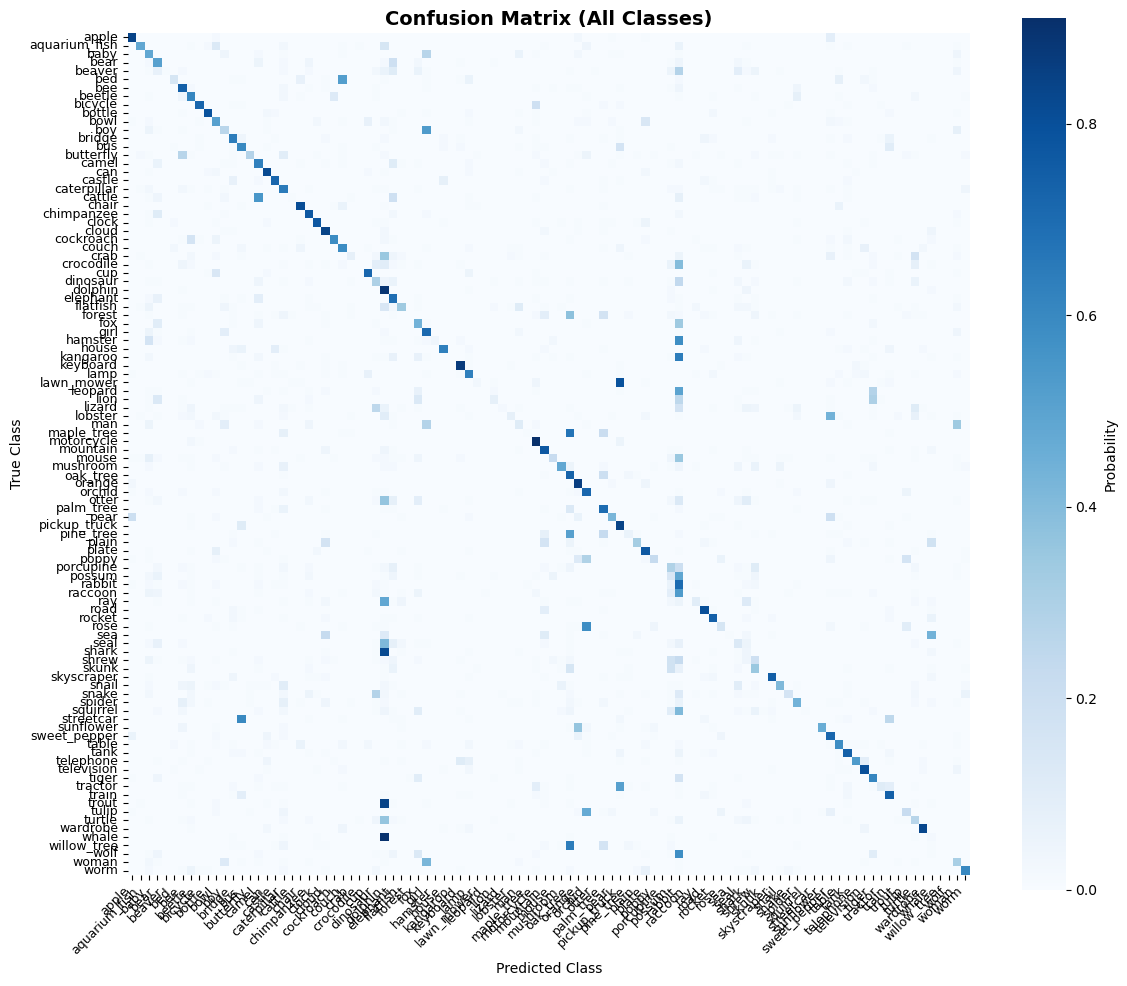


📸 Creating retrieval examples...


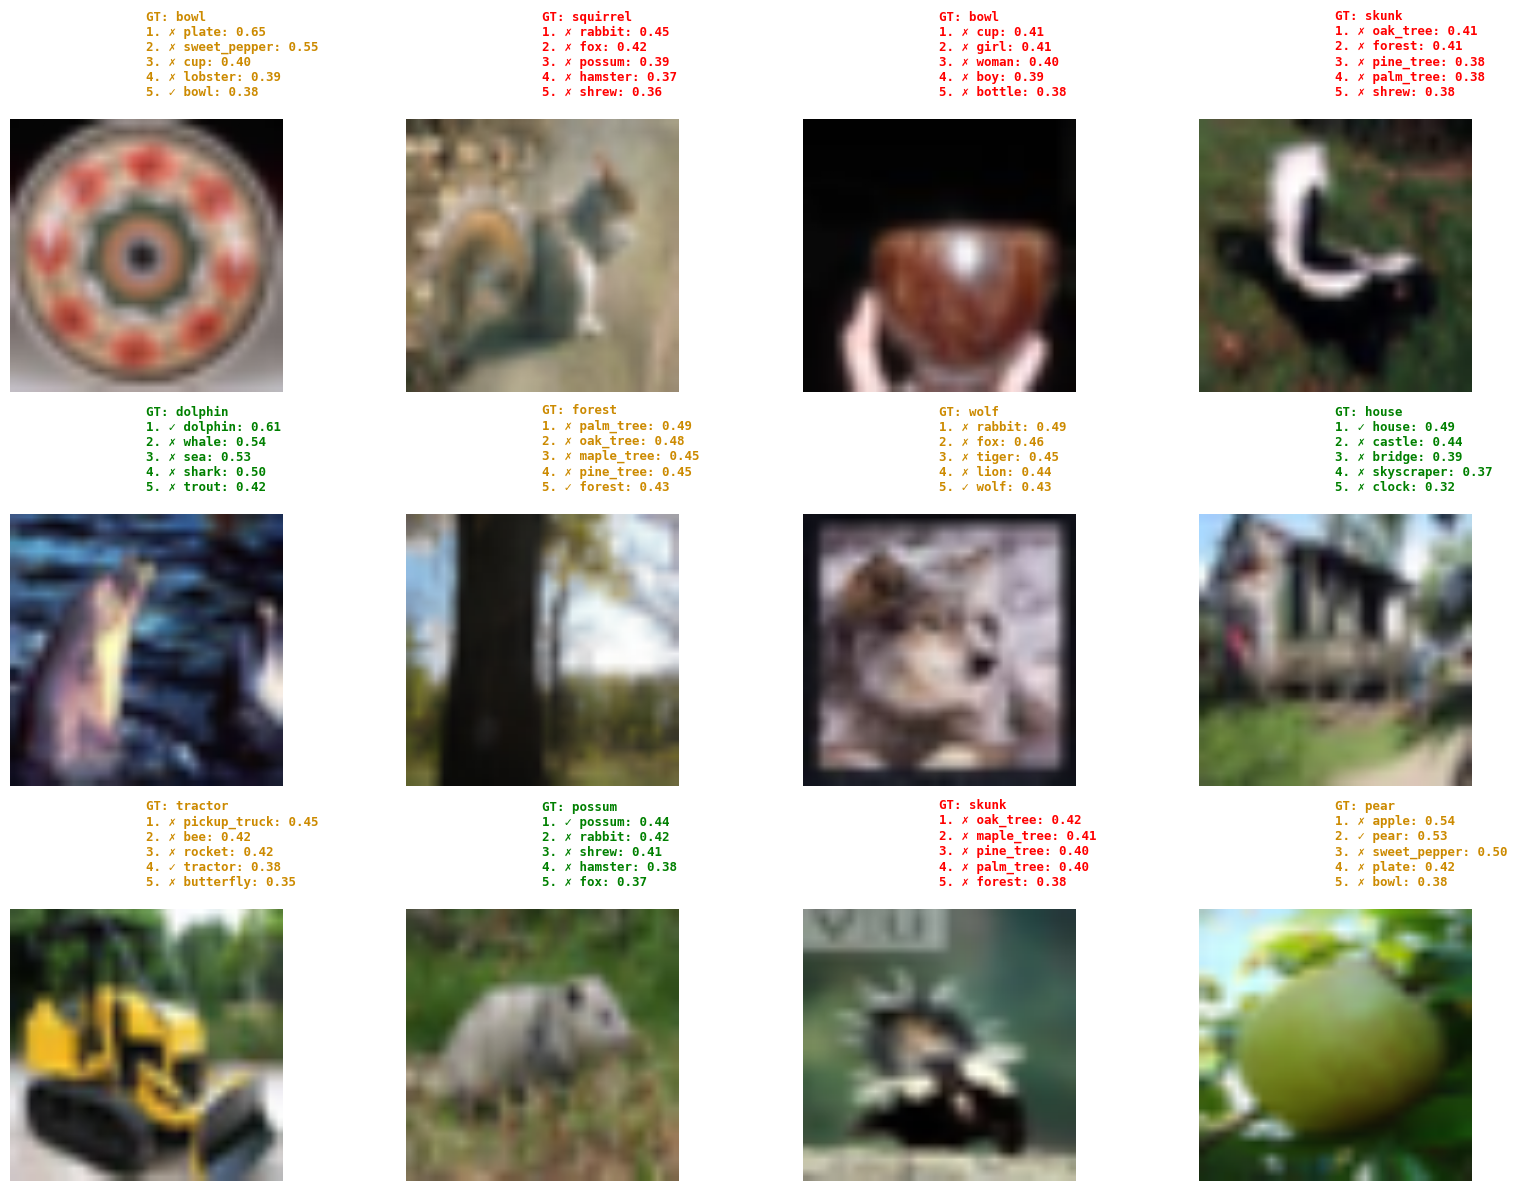


QUALITATIVE EVALUATION

📸 Example Image-to-Text Retrievals:
----------------------------------------------------------------------

Test Image #6463:
  True class: 'bee' (similarity: 0.5074, rank: 1)
  Top 5 predictions:
    1. ✓ bee             (similarity: 0.5074)
    2.   butterfly       (similarity: 0.3500)
    3.   cloud           (similarity: 0.2987)
    4.   rocket          (similarity: 0.2909)
    5.   apple           (similarity: 0.2799)

Test Image #7427:
  True class: 'leopard' (similarity: 0.3816, rank: 7)
  Top 5 predictions:
    1.   rabbit          (similarity: 0.4511)
    2.   lion            (similarity: 0.4295)
    3.   dinosaur        (similarity: 0.4281)
    4.   tiger           (similarity: 0.4088)
    5.   lizard          (similarity: 0.3831)

Test Image #7849:
  True class: 'crab' (similarity: 0.4279, rank: 2)
  Top 5 predictions:
    1.   dolphin         (similarity: 0.4758)
    2. ✓ crab            (similarity: 0.4279)
    3.   seal            (similarity: 0.4

In [15]:
# =============================================================================
# VISUALIZATIONS (using training classes)
# =============================================================================
print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

# Creates and saves confusion matrix and retrieval examples (plots are shown interactively)
create_visualizations(sim_matrix, all_labels, class_words, label_to_word, test_idx)

# =============================================================================
# QUALITATIVE EVALUATION (using training classes)
# =============================================================================
print("\n" + "="*70)
print("QUALITATIVE EVALUATION")
print("="*70)

# Prints text-based examples of image-to-text retrieval for a random sample of test images
print_example_retrievals(sim_matrix, all_labels, class_words, label_to_word)


OUT-OF-DISTRIBUTION IMAGE ANALYSIS

🔬 Using FULL vocabulary (523 words) for OOD predictions
   (Training only learned to separate 100 classes)

  ✓ Downloaded: jellyfish
  ✓ Downloaded: goldfish
  ✓ Downloaded: flamingo
  ✓ Downloaded: pizza
  ✓ Downloaded: strawberry
  ✓ Downloaded: hotdog
  ✓ Downloaded: banana
  ✓ Downloaded: parachute
  ✓ Downloaded: school_bus
  ✓ Downloaded: volcano
  ✓ Downloaded: submarine
  ✓ Downloaded: accordion
  ✓ Downloaded: hourglass
  ✓ Downloaded: revolver
  ✓ Downloaded: dome
  ✓ Downloaded: bobsled

🔬 Processing 16 OOD images...

📸 Creating OOD visualization for 16 images...


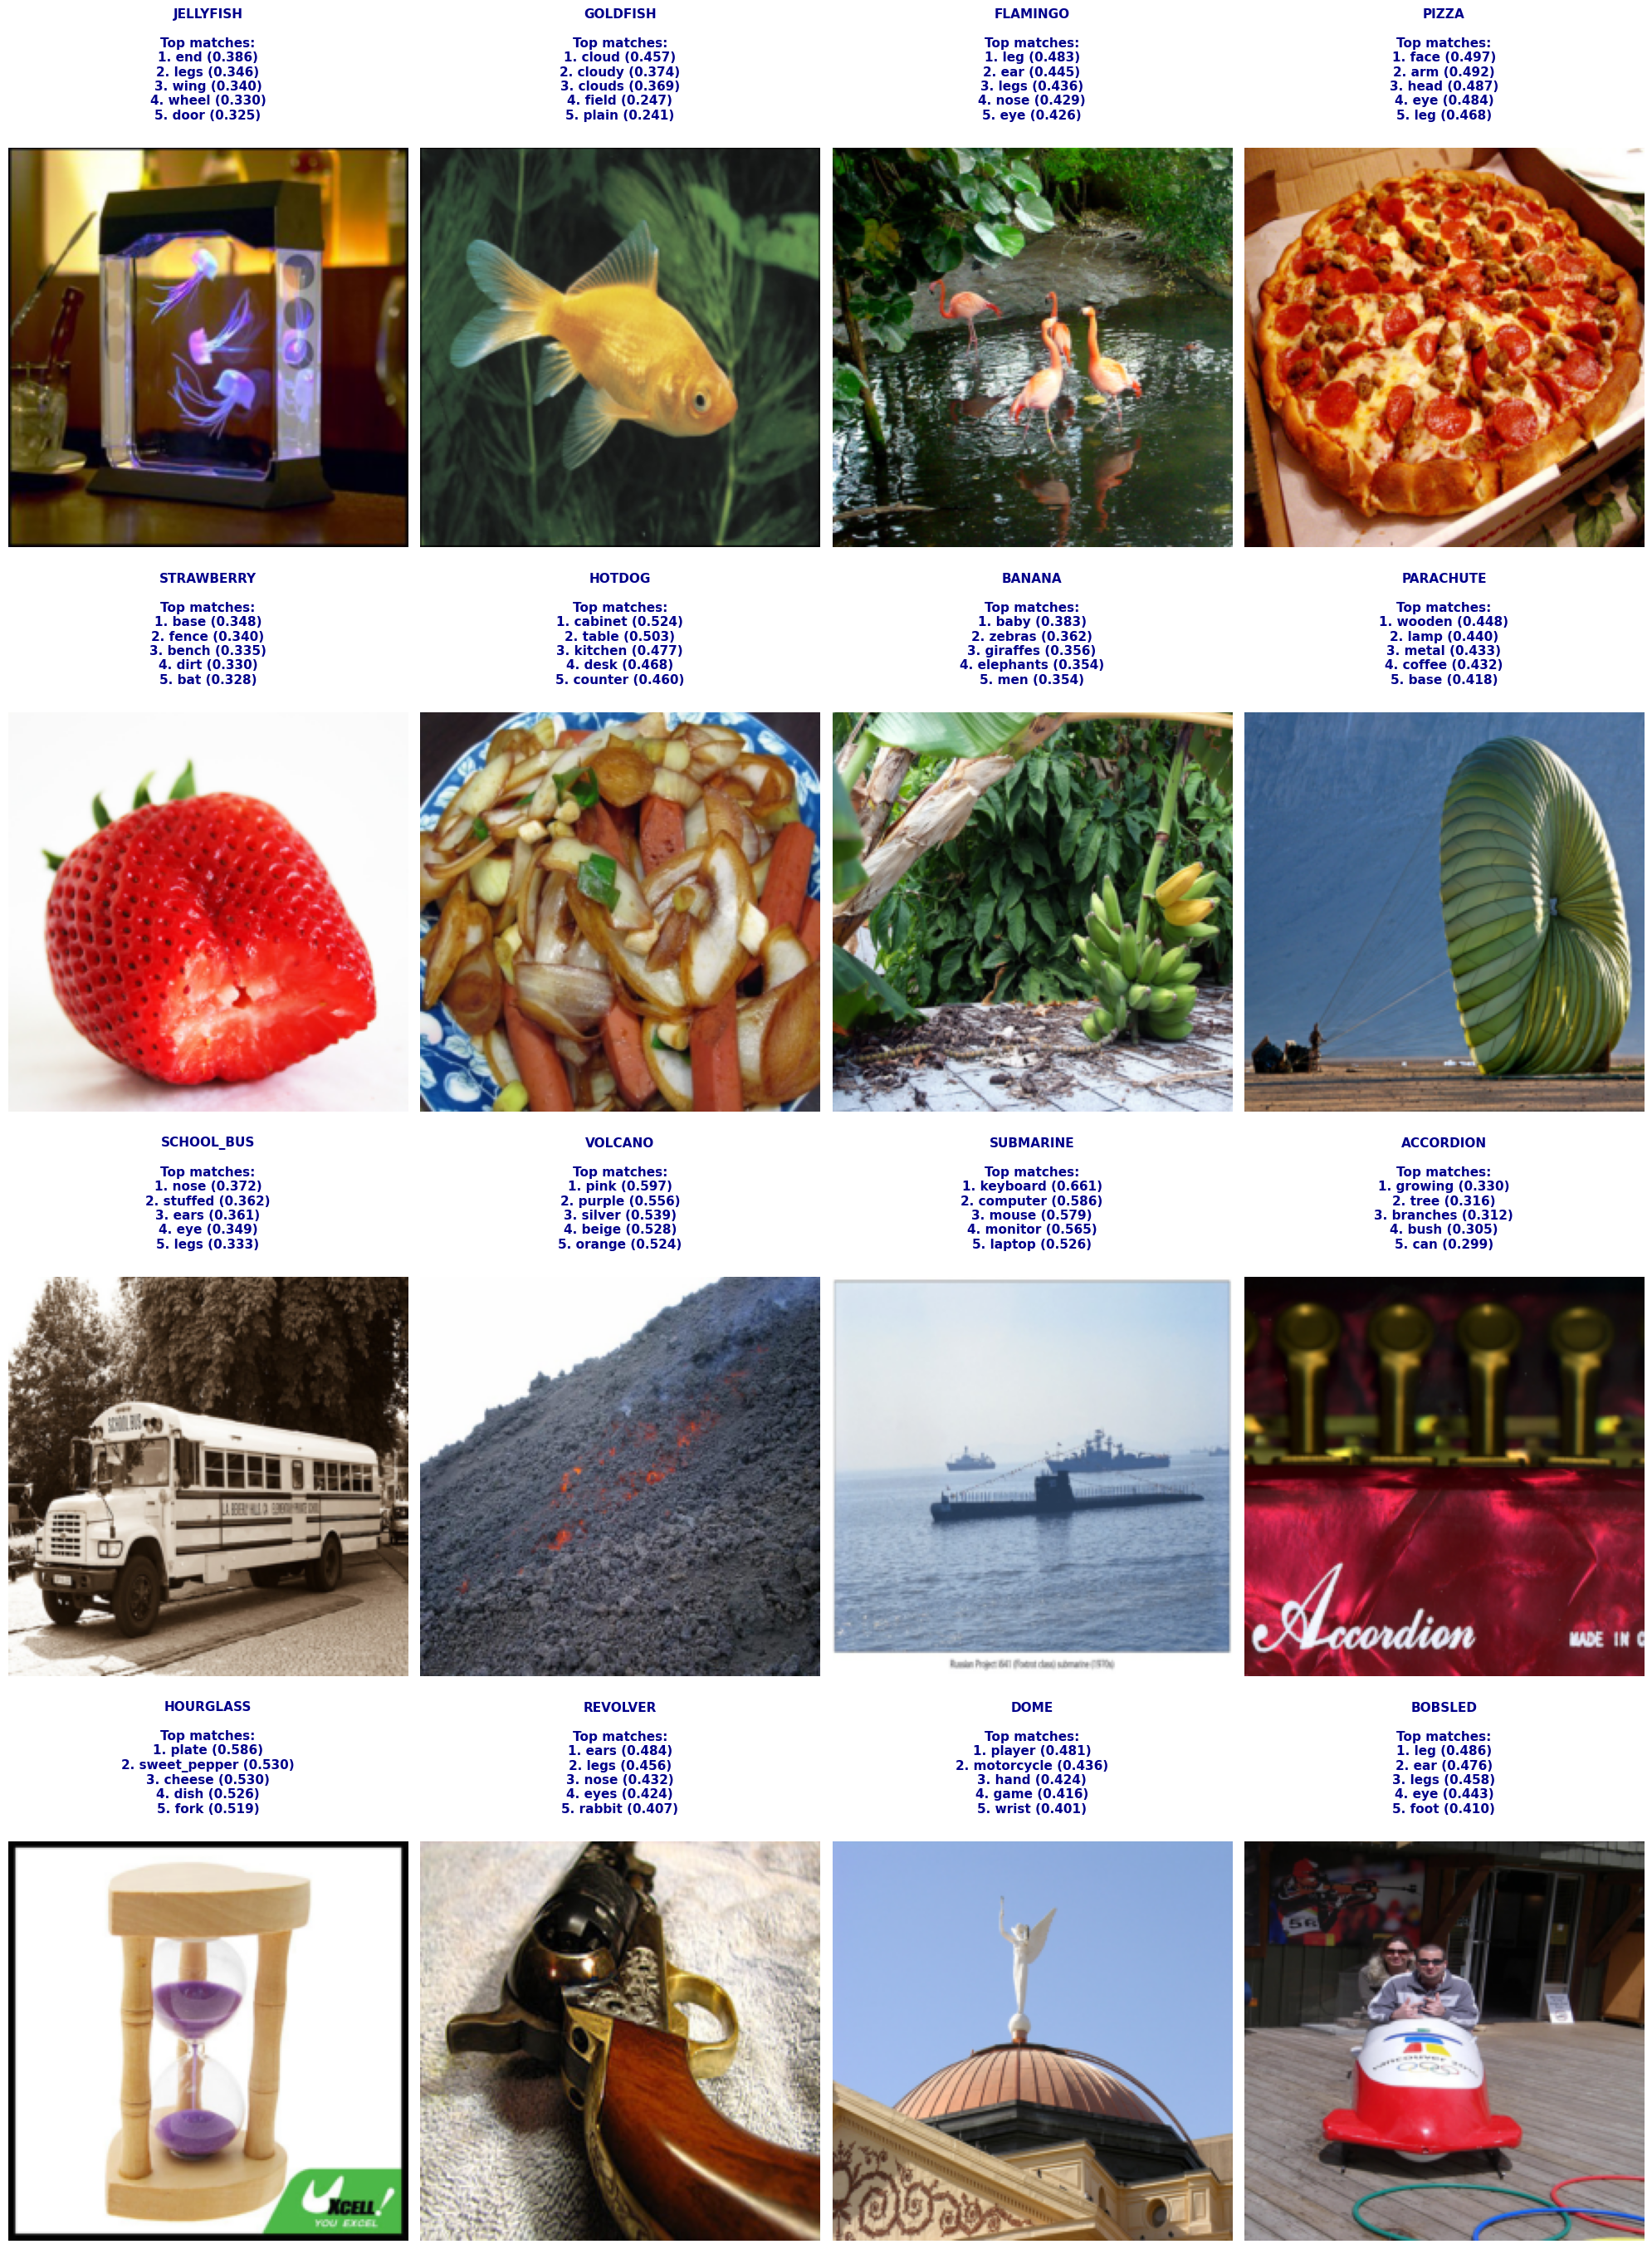

In [16]:
# OOD test images (samples outside of the CIFAR-100 domain)
OOD_URLS = {
    "jellyfish": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01910747_jellyfish.JPEG",
    "goldfish": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01443537_goldfish.JPEG",
    "flamingo": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02007558_flamingo.JPEG",
    "pizza": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n07873807_pizza.JPEG",
    "strawberry": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n07745940_strawberry.JPEG",
    "hotdog": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n07697537_hotdog.JPEG",
    "banana": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n07753592_banana.JPEG",
    "parachute": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n03888257_parachute.JPEG",
    "school_bus": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n04146614_school_bus.JPEG",
    "volcano": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n09472597_volcano.JPEG",
    "submarine": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n04347754_submarine.JPEG",
    "accordion": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02672831_accordion.JPEG",
    "hourglass": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n03544143_hourglass.JPEG",
    "revolver": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n04086273_revolver.JPEG",
    "dome": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n03220513_dome.JPEG",
    "bobsled": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02860847_bobsled.JPEG",
}

# =============================================================================
# OOD IMAGE ANALYSIS (using ALL vocabulary words)
# =============================================================================
print("\n" + "="*70)
print("OUT-OF-DISTRIBUTION IMAGE ANALYSIS")
print("="*70)

print(f"\n🔬 Using FULL vocabulary ({len(all_vocab_words):,} words) for OOD predictions")
print(f"   (Training only learned to separate {len(class_words)} classes)")

# This function processes the OOD images and calculates predictions against the full vocabulary.
# all_text_emb was prepared in STAGE 4 and contains embeddings for all {vocab_size} VG words.
ood_images, ood_names, ood_predictions = process_ood_images(
    vision_model, OOD_URLS, all_text_emb.cpu().numpy(), all_vocab_words, device
)

# If any images were successfully downloaded and processed, generate a visualization.
if len(ood_images) > 0:
    # The visualization function is reused, but now receives the OOD data
    # (images, names, predictions) to create a dedicated analysis plot.
    create_visualizations(sim_matrix, all_labels, class_words, label_to_word, test_idx,
                         ood_images, ood_names, ood_predictions)

In [17]:
# =============================================================================
# FINAL REPORT
# =============================================================================
# The final report function gathers all collected metrics and parameters
# (from TRAIN_CONFIG, test results, retrieval metrics, and OOD analysis)
# to print a comprehensive, structured summary.

print_final_report(
    TRAIN_CONFIG, test_loss, test_sim, i2t_recalls, t2i_recalls, class_stats,
    len(train_idx), len(val_idx), len(test_idx), len(class_words),
    TRAIN_CONFIG['batch_sizes']['train'], len(ood_images) > 0,
    history, best_epoch, best_val_sim, best_val_loss, len(all_vocab_words)
    )


📋 Training Configuration:
   ├─ Model: MobileNetV3-Small with projection head
   ├─ Embedding dimension: 96
   ├─ Training samples: 40,000, Validation samples: 10,000, Test samples: 10,000
   ├─ Number of training classes: 100
   ├─ Total vocabulary size: 523 words
   ├─ Total epochs trained: 35, Best epoch: 35
   └─ Early stopping patience: 13

🎯 Performance Metrics:
   ├─ Best Val Similarity: 0.4279
   ├─ Test Similarity: 0.4299, Test Loss: 3.9950
   ├─ Random baseline loss: ~6.24
   │
   ├─ Image→Text Recall@1: 41.83%
   ├─ Image→Text Recall@5: 74.04%
   ├─ Image→Text Recall@10: 83.99%
   │
   ├─ Text→Image Recall@1: 72.00%
   ├─ Text→Image Recall@5: 95.00%
   └─ Text→Image Recall@10: 99.00%

📊 Embedding Space Alignment:
   ├─ Mean per-class similarity: 0.4299 ± 0.0976
   ├─ Best aligned class: 'can' (0.6683)
   └─ Worst aligned class: 'mouse' (0.1894)

💡 Key Insights:
   • The model attempts to learn visual-text alignment
   • Low overall alignment (similarity: 0.4299)
   • Loss: 

In [15]:
from lab8 import run_tests

run_tests()

test_custom_transform_applied (lab8.TestCIFAR100Filtered.test_custom_transform_applied)
Test that custom transforms are applied. ... ok
test_getitem_returns_tuple (lab8.TestCIFAR100Filtered.test_getitem_returns_tuple)
Test that __getitem__ returns (image, label) tuple. ... ok
test_invalid_split_raises_error (lab8.TestCIFAR100Filtered.test_invalid_split_raises_error)
Test that invalid split raises AssertionError. ... ok
test_train_split_creation (lab8.TestCIFAR100Filtered.test_train_split_creation)
Test that train split is created correctly. ... ok
test_val_split_uses_test_set (lab8.TestCIFAR100Filtered.test_val_split_uses_test_set)
Test that val split uses train=False. ... ok
test_backbone_frozen (lab8.TestImageEncoder.test_backbone_frozen)
Test that backbone parameters are frozen. ... ok
test_different_projection_dims (lab8.TestImageEncoder.test_different_projection_dims)
Test model with different projection dimensions. ... 

RUNNING LAB 8 UNIT TESTS


ok
test_forward_gradient_control (lab8.TestImageEncoder.test_forward_gradient_control)
Test gradient flow control. ... ok
test_forward_output_shapes (lab8.TestImageEncoder.test_forward_output_shapes)
Test that forward pass returns correct shapes. ... ok
test_model_initialization (lab8.TestImageEncoder.test_model_initialization)
Test that model initializes without errors. ... ok
test_no_nan_outputs (lab8.TestImageEncoder.test_no_nan_outputs)
Test that forward pass doesn't produce NaN. ... ok
test_projection_head_structure (lab8.TestImageEncoder.test_projection_head_structure)
Test projection head architecture. ... ok
test_projection_trainable (lab8.TestImageEncoder.test_projection_trainable)
Test that projection head parameters are trainable. ... ok
test_batch_size_one (lab8.TestComputeContrastiveLoss.test_batch_size_one)
Test with batch size 1. ... ok
test_gradient_flow (lab8.TestComputeContrastiveLoss.test_gradient_flow)
Test gradient flow. ... ok
test_loss_computation (lab8.TestCompu


✅ ALL TESTS PASSED!
Total tests run: 41


True